In [2]:
from IPython.display import Image
import matplotlib.pyplot as plt

# [Albumentations](https://github.com/albumentations-team/albumentations#pixel-level-transforms)

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

# [Object Detection](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/) в albumentations

У **bounding box** есть верхний левый угол с координатами $(x\_min, y\_min)$ и нижний правый $-$ $(x\_max, y\_max)$. С помощью них в **albumentations** придумали различные форматы задания **bounding box**.

## Способы задать bounding box в albumentations:

1. **pascal_voc** $-$ формат, используемый набором данных Pascal VOC.

    Координаты ограничивающего прямоугольника кодируются четырьмя значениями в пикселях: $[x\_min, \,y\_min, \,x\_max, \,y\_max]$. $\newline$
    
2. **albumentations** $-$ собственный способ представления рамок, используемый внутри albumentations. 

    В отличие от **pascal_voc**, формат **albumentations** использует нормализованные значения. Для нормализации используются ширина и высота изображения. Формат: $[\frac{x\_min}{W}, \frac{y\_min}{H}, \frac{x\_max}{W}, \frac{y\_max}{H}]$, где $W$ и $H$ $-$ ширина и высота изображения соответственно.  $\newline$

3. **coco** $-$ формат, используемый набором данных Common Objects in Context.

    Здесь первые два числа – это координаты верхнего левого угла, а следующие два – ширина и высота **рамки** (в абсолютных пикселях). Формат: $[x\_min, \,y\_min, \,w, \,h]$, где $w$ и $h$ $-$ ширина и высота **рамки** соответственно.  $\newline$
    
4. **yolo** $-$ формат Ultralytics YOLO.

    Формат **yolo** задаёт рамку через координаты её центра, а также ширину и высоту. При этом все значения нормализованы относительно размеров изображения – то есть они находятся в диапазоне $[0, 1]$. Формат: $[x\_center, y\_center, w\,', h\,']$, где $x\_center=\frac{x\_min\,+\,x\_max}{2\,\cdot \,W};$ $y\_center=\frac{y\_min\,+\,y\_max}{2\,\cdot \,H};$ $w\,'=\frac{x\_max\,-\,x\_min}{W};$ $h\,'=\frac{y\_max\,-\,y\_min}{H};$, где $W$ и $H$ $-$ ширина и высота изображения соответственно.

# Compose в albumentations

Пример:

```python
transform = A.Compose([
    A.RandomCrop(width=450, height=450),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='coco'))
```

У **Compose** для bounding box аугментации есть параметр **bbox_params**, в который нужно передать **A.BboxParams** с некоторыми параметрами.

### A.BboxParams

**Параметры:**

**format** - задает формат координат ограничивающих рамок. Значения:

- **pascal_voc**

- **albumentations**

- **coco**

- **yolo**

**[min_area](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/#:~:text=min_area%20and%20min_visibility%20parameters)** - минимальная площадь в пикселях. Если площадь ограничивающего прямоугольника после аугментации становится меньше **min_area**, albumentations удалит этот прямоугольник. Поэтому возвращаемый список ограничивающих прямоугольников не будет содержать этот ограничивающий прямоугольник.

**[min_visibility](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/#:~:text=min_area%20and%20min_visibility%20parameters)** - задает минимальную долю исходной площади рамки, которая должна остаться видимой после аугментации. После применения трансформаций вычисляется, какая часть исходной рамки осталась в пределах изображения. Если эта доля меньше указанного порога, рамка отбрасывается. Это полезно для исключения слишком «обрезанных» рамок, которые могут негативно сказаться на обучении модели.

**[label_fields](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/#:~:text=label_fields%20parameter)** - список имен полей, в которых содержатся метки (labels) для соответствующих bounding boxes. При аугментации вместе с рамками корректируются («переназначаются» к уже обновлённым координатам) и значения из указанных полей, чтобы сохранить соответствие между рамками и их метками. Если ограничивающий прямоугольник удаляется после трансформации, поскольку он больше не виден, albumentations также удаляет метку класса для этого прямоугольника. В этот список можно задать несколько полей, чтобы можно было передать несколько меток:

```python
transform = A.Compose([
    A.RandomCrop(width=450, height=450),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='coco', label_fields=['class_labels', 'class_categories']))

class_labels = ['cat', 'dog', 'parrot']
class_categories = ['animal', 'animal', 'item']

transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels, class_categories=class_categories)
transformed_image = transformed['image']
transformed_bboxes = transformed['bboxes']
transformed_class_labels = transformed['class_labels']
transformed_class_categories = transformed['class_categories']
```

**clip** - если **True**, координаты ограничивающего прямоугольника обрезаются, чтобы оставаться в пределах границ изображения перед применением преобразований. По умолчанию: **False**.

**filter_invalid_bboxes** - если **True**, удаляет недопустимые поля (x_max < x_min или y_max < y_min) перед применением преобразований. Если **clip=True**, удаление происходит после обрезки. По умолчанию: **False**.

# OneOf

Берется список преобразований и применяется ровно одно из них, выбранное случайным образом, причем Albumentations нормализует вероятности внутренних преобразований так, чтобы их сумма равнялась 1. 

Например:

**HorizontalFlip** имеет **p=0.9**

**RandomBrightnessContrast** имеет **p=0.7**

Сумма составляет 0.9 + 0.7 = 1.6

Нормализованная вероятность для **HorizontalFlip**: 0.9 / 1.6 = 0.5625. Нормализованная вероятность для **RandomBrightnessContrast**: 0.7 / 1.6 = 0.4375. Таким образом, если **OneOf** сработает, **HorizontalFlip** будет применена в 56,25% случаев, а **RandomBrightnessContrast** будет применена в 43,75% случаев.

```python
A.OneOf([
    A.HorizontalFlip(p=0.9),
    A.RandomBrightnessContrast(p=0.7)
], p=0.5)  # вероятность 50% применить одно из вышеперечисленных преобразований
```

Так как **OneOf** в примере тоже имеет вероятность применения = 0.5, то фактическая вероятность применения каждого конкретного преобразования к исходному изображению составляет:

**HorizontalFlip**: 0.5 * 0.5625 ~ 0.28

**RandomBrightnessContrast**: 0.5 * 0.4375 ~ 0.22

# SomeOf

Случайным образом выбирает **n** преобразовании из списка и пытается применить их последовательно. Она хорошо подходит, когда нужно одновременно разнообразить аугментации, но не применять все или не применять ровно одну (в отличие от **OneOf**). 

**n** - количество выбранных преобразований. Значения: **int** или **tuple(int, int)** - диапазон.

**replace** - если **False**, выбор без замены: трансформы не повторяются в одном вызове. Если **True**, выбор с заменой: один и тот же трансформ может быть выбран несколько раз. По умолчанию **False**.

**p** - вероятность того, что **SomeOf** блок вообще выполнится.

```python
A.SomeOf([
    A.GaussianBlur(p=0.5), # Если выбран, 50% шанс к применению
    A.RandomBrightnessContrast(p=1.0), # Если выбран, 100% шанс к применению
    A.HueSaturationValue(p=0.8), # Если выбран, 80% шанс к применению
    A.Sharpen(p=0.3), # Если выбран, 30% шанс к применению
], n=(1, 3), p=0.9)
```

Каждый трансформ из списка имеет своё собственное поле **p**. После выбора **n** кандидатов блок по очереди пытается применить каждый из них, и каждый срабатывает только если его индивидуальный **p** прошёл случайную проверку.

# Sequential

Применяет список преобразований последовательно, как и **A.Compose**. У **Sequential** есть параметр **p** (вероятность применения) и если случайная проверка не удалась, то ни одно из преобразований внутри него не применяется. Предназначен для вложенных группировок внутри **A.Compose**. Стоит использовать тогда, когда всю последовательность операций можно представить как единый блок аугментации, который либо выполняется полностью, либо не выполняется вообще на основе одного значения вероятности.

```python
A.Sequential([
    A.HorizontalFlip(p=1.0), # Всегда применяется, если Sequential сработал
    A.RandomBrightnessContrast(p=1.0) # Всегда применяется, если Sequential сработал
], p=0.4)
```

# Оптимизации в Albumentations

**[Ссылка](https://albumentations.ai/docs/3-basic-usage/choosing-augmentations/)** и **[Ссылка](https://albumentations.ai/docs/3-basic-usage/performance-tuning/)**

### 1. Предпочтение uint8 вместо float32

Albumentations поддерживает и **uint8** (0–255), и **float32** (0.0–1.0). Однако большинство внутренних функций OpenCV, используемые Albumentations, оптимизированы именно под **uint8**, что делает операции быстрее или как минимум не медленнее, чем с **float32**.

- **Важно**: если всё же подаётся **float32**, нужно убедится, что значения нормированы в $[0.0, 1.0]$, иначе они будут автоматически обрезаны (обрезка делается только для определенных трансформации, например, для **RandomBrightnessContrast**, который меняет яркость, но для геометрических трансформации, как правило, не делается. Например, **HorizontalFlip** просто копирует пиксели без изменения их значений). $\newline$

- **Рекомендация**: следует проводить основные аугментации на **uint8**, а нормализацию (**A.Normalize**) оставить на финальный этап — эта трансформация сама конвертирует **uint8** в **float32** с нужным масштабированием.

### 2. Обрезать изображение сразу

Применение трансформаций к меньшим изображениям значительно ускоряется, поскольку обрабатывается меньше пикселей. Пример, обрезка с 1024×1024 до 256×256 уменьшает число пикселей в 16 раз, и все последующие операции будут выполняться на уменьшенной области. 

- **Рекомендация**: следует ставить преобразования по типу **CenterCrop**, **RandomCrop** или **RandomResizedCrop** перед всеми другими аугментациями в **Compose**. 

```python
pipeline = A.Compose([
    A.RandomResizedCrop(height=224, width=224, scale=(0.8, 1.0), p=1.0),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    # ... Другие трансформации на изображении 224x224 ...
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
```

### 3. Объединять похожие трансформации

Чем меньше отдельных шагов, тем меньше накладных расходов на обход пайплайна.

- Например, вместо отдельных операций паддинга и кропа можно использовать **pad_if_needed=True** внутри трансформаций **Crop**, **CenterCrop** или **RandomCrop**. $\newline$

- Вместо двух отдельных зеркальных отражений (**HorizontalFlip** + **VerticalFlip**) можно применить **SquareSymmetry** (**D4**) для четырёх симметрий сразу. $\newline$

- Вместо того чтобы раздельно вращать и масштабировать, стоит использовать **Affine**, который обрабатывает вращение, масштабирование, перемещение и сдвиг за одну операцию.

### 4. Оптимизировать чтение изображений

Способ чтения файлов изображений с диска существенно влияет на общую скорость всего обучения. Например, стандарт **PIL ( Pillow )** часто медленнее альтернатив.

- **Рекомендация**: вместо **Pillow** (**PIL**) следует использовать **cv2.imread** из OpenCV или **torchvision.io.read_image** — они существенно быстрее, особенно для JPEG.

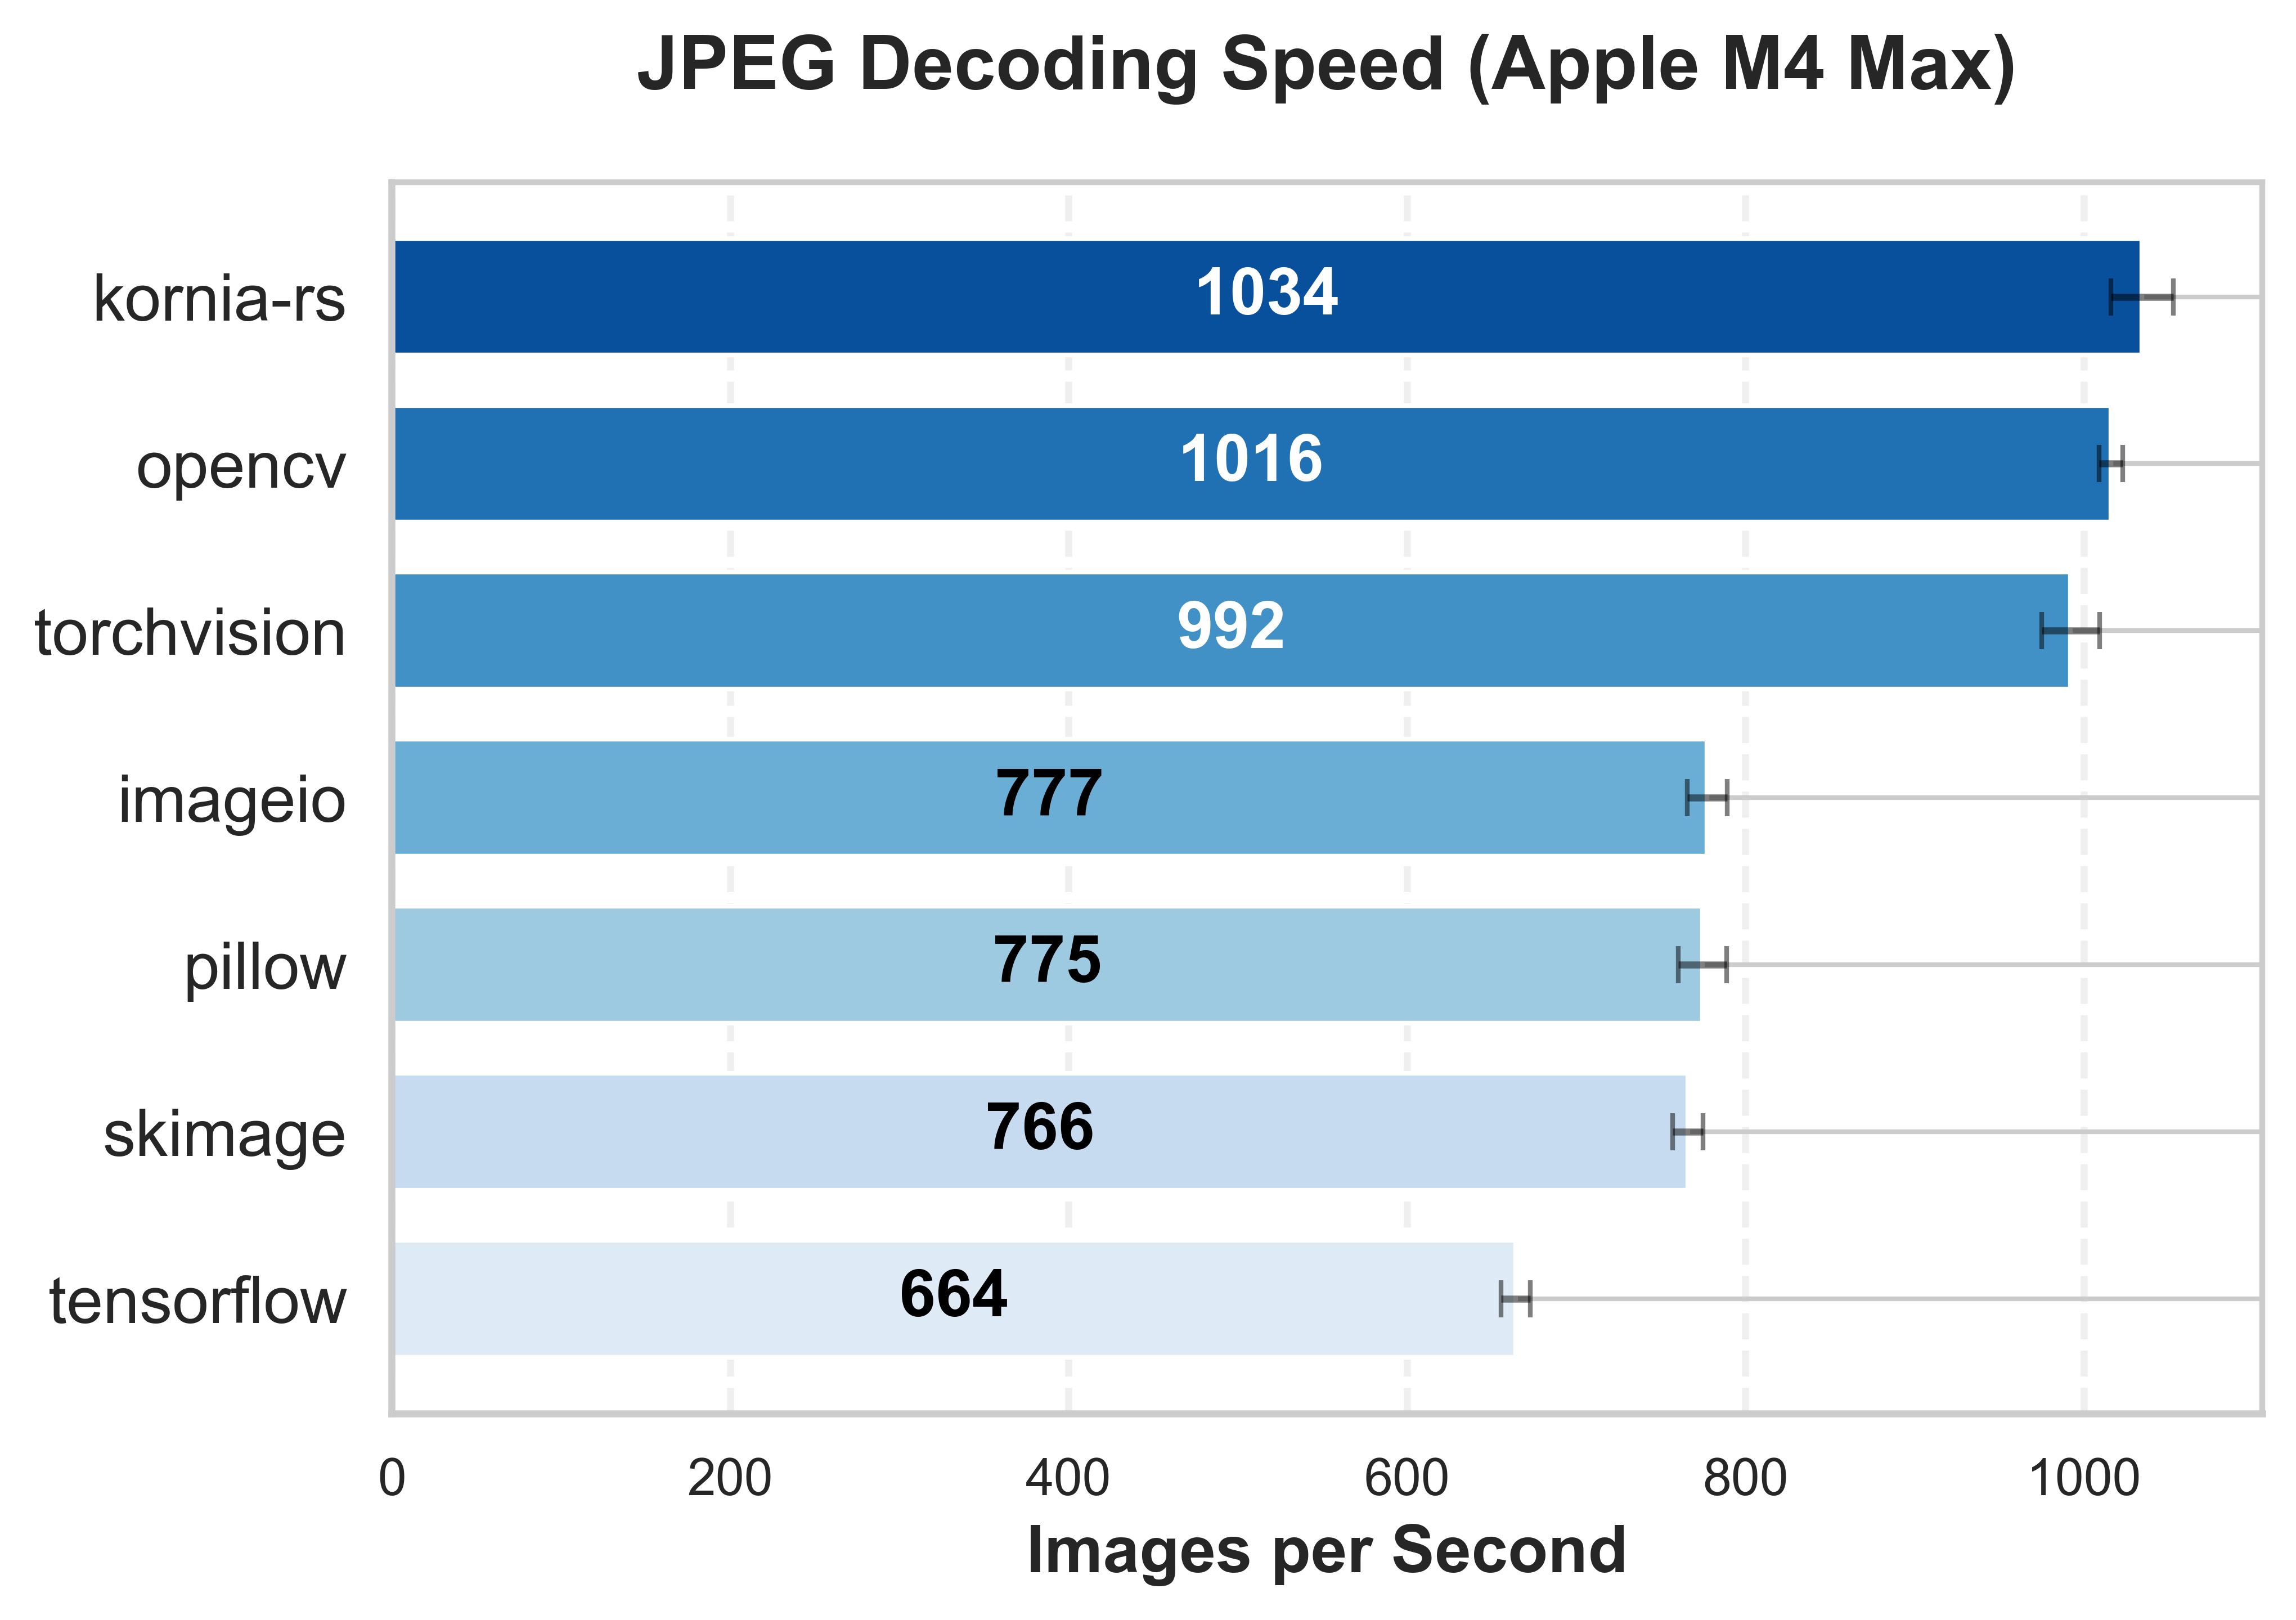

In [7]:
Image("jpeg_decoding.png", width="80%")

### 5. Избегать конфликтов многопроцессорности (OpenCV & PyTorch)

При использовании DataLoader с num_workers > 0 OpenCV по умолчанию может порождать свои потоки, что приводит к соперничеству за CPU и общему снижению скорости. Это часто происходит потому, что OpenCV (**cv2**) - бэкэнд для многих преобразований Albumentations, поэтому OpenCV может попытаться распараллелить свои собственные операции с использованием нескольких потоков.

- **Решение**: нужно заставить OpenCV работать в однопоточном режиме в каждом рабочем процессе. Для этого следует добавить этот код в начало обучающего скрипта:

```python
import cv2
cv2.setNumThreads(0)
# cv2.ocl.setUseOpenCL(False)
```

- Настройка **cv2.setNumThreads(0)** не позволяет OpenCV создавать собственный пул потоков в каждом рабочем процессе, что позволяет многопроцессорной обработке PyTorch эффективно управлять параллелизмом.

# Метрика mean average precision (mAP)

**[Хорошее объяснение](https://www.youtube.com/watch?v=LWiiHqI4Bg8&t=3273s&ab_channel=%D0%95%D0%B2%D0%B3%D0%B5%D0%BD%D0%B8%D0%B9%D0%A0%D0%B0%D0%B7%D0%B8%D0%BD%D0%BA%D0%BE%D0%B2)**

Метрика качества Mean Average Precision – это ключевая метрика для оценки качества моделей обнаружения объектов на изображении. Она позволяет численно оценить, насколько хорошо модель находит и правильно классифицирует объекты на изображении. 

**IoU** – показатель, который определяет, насколько хорошо совпадают 2 ограничивающих прямоугольника. Во время обучения нейросети у нас есть истинные и предсказанные ограничивающие прямоугольники и для них нужно определить, насколько хорошо предсказанные рамки совпадают с истинными. **IoU** вычисляется как площадь пересечения двух рамок, деленная на площадь их объединения. Значения **IoU** находятся в диапазоне от 0 до 1.

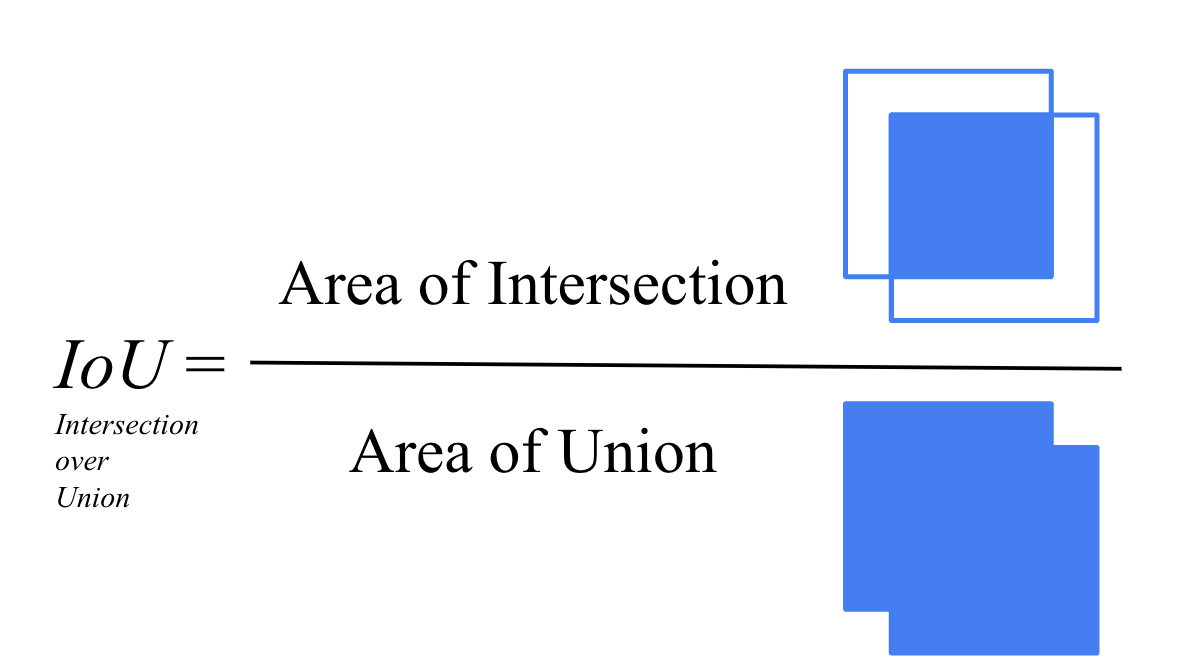

In [5]:
Image("IoU.png", width="60%")

Чтобы понять принцип работы **Mean Average Precision**, нужно сначала разобраться с показателями **Intersection over Union** (**IoU**), **True Positive**, **False Positive**, **False Negative** и метриками **Precision**, **Recall**.

**True Positive** (**TP**) – ситуация, когда модель правильно обнаружила объект определенного класса. Считается, что модель правильно обнаружила объект, если:
- Предсказанный ограничивающий прямоугольник имеет правильный класс. $\newline$
- Показатель **IoU** между предсказанным и соответствующим истинным ограничивающим прямоугольником больше или равно некоторого заданного порога. $\newline$
- Этот истинный ограничивающий прямоугольник еще не был обнаружен, так как одна истинная рамка может соответствовать только одному **True Positive**. $\newline$

**False Positive** (**FP**) – ситуация, когда модель обнаружила ограничивающий прямоугольник, которого нет на самом деле, или обнаружила неправильно. Это происходит, если:
- Предсказанный ограничивающий прямоугольник не соответствует ни одному истинному. $\newline$
- Предсказанный ограничивающий прямоугольник соответствует истинной рамке, но **IoU** меньше заданного порога. $\newline$
- Предсказанный ограничивающий прямоугольник имеет неправильный класс. $\newline$
- Несколько предсказанных ограничивающих прямоугольников соответствуют одному и тому же истинному ограничивающему прямоугольнику. В этом случае одна засчитывается как **True Positive**, а другая как **False Positive**. $\newline$

**False Negative** (**FN**) – ситуация, когда модель не предсказала ограничивающий прямоугольник, хотя он присутствует на изображении.

---

Дальнейшие метрики вычисляются для определенного порога уверенности модели. Модель на выходе выдает множество ограничивающих прямоугольников с разной уверенностью. При каждом уникальном пороге уверенности рассматриваются только те ограничивающие прямоугольники, уверенность которых выше порога.

**Precision** (точность) – метрика, которая показывает долю правильно обнаруженных ограничивающих прямоугольников среди всех предсказанных. 

$$Precision=\frac{TP}{TP+FP};$$

Высокий **Precision** означает, что среди предсказаний модели мало ложных предсказаний. Значения находятся в диапазоне от 0 до 1.

**Recall** (полнота) – метрика, которая показывает долю правильно обнаруженных ограничивающих прямоугольников среди всех истинных ограничивающих прямоугольников. 

$$Recall=\frac{TP}{TP+FN};$$

Высокий **Recall** означает, что модель нашла большинство реальных объектов на изображении. Значения находятся в диапазоне от 0 до 1.

Обе метрики очень важны, поэтому часто стоит задача максимизировать их, но проблема в том, что **Precision** и **Recall** сильно зависят от порога уверенности, который выбирается для моделей обнаружения объектов на изображении. При снижении порога уверенности обычно увеличивается **Recall**, но снижается **Precision**. При повышении порога уверенности растет **Precision**, а **Recall** снижается. Для решения этой проблемы можно использовать **Precision-Recall** кривую, которая призвана найти компромисс между точностью и полнотой. 

---

**Average Precision** (**AP**) – метрика, которая вычисляется как площадь под **Precision-Recall** кривой для конкретного класса. Чем больше эта площадь, тем лучше работает модель для конкретного класса, то есть лучше баланс между точностью и полнотой. Площадь под кривой считается с помощью интерполяции в 11 точках **Recall** или с помощью точного вычисления площади под ступенчатой кривой.

**Mean Average Precision** (**mAP**) – метрика, которая считается как среднее между всеми **Average Precision** для всех классов.

$$mAP=\frac{1}{N}\sum_{i=1}^{N}{AP}_i;$$

где N – количество классов.

Важно понимать, что метрика **Mean Average Precision** зависит от порога **IoU**, который выбирается заранее. Чтобы исключить эту зависимость, часто считают метрику **Mean Average Precision** (**mAP@[.5:.95]**), которая усреднена по всем порогам **IoU** от 0.5 до 0.95 с шагом 0.05. Такая метрика более строго оценивает точность локализации объектов на изображении. 

---

Алгоритм для одного изображения и одного класса:

1. **Фильтрация и сортировка предсказаний:**

    - Берем только те предсказанные рамки, класс которых совпадает с нашим целевым классом. $\newline$

    - Сортируем эти предсказанные рамки в порядке убывания оценки уверенности модели (от самой уверенной до наименее уверенной).$\newline$ 
    
    - Также мы работает только с истинными рамками целевого класса, все остальные объекты других классов на изображении полностью игнорируются. $\newline$
    
2. **Инициализация:**

    - Создаем список (или флаги) для всех истинных рамок на этом изображении, отмечая каждую как "несопоставленная". $\newline$

    - Обнуляем счетчики **TP**, **FP**, **FN**. $\newline$
    
3. **Перебор предсказанных рамок (начиная с самой уверенной):**

    - Идем по предсказанным рамкам из отсортированного списка (из шага 1) одну за другой. $\newline$
    
    - Переход от одного предсказанного бокса к следующему можно назвать одним шагом. После каждого шага происходит обновление кумулятивных (накопленных) счетчики `TP`, `FP` и пересчитываются `Precision` и `Recall`. Полученные значения `Precision` и `Recall` сохраняются для каждого шага, чтобы в конце посчитать площадь под полученной кривой.$\newline$
    
4. **Для текущей предсказанной рамки:**

    - Вычисляем **IoU** между этой предсказанной рамкой и **каждой** истинной рамкой на изображении (смотрим на все истинные боксы вне зависимости от того, сопоставлен он или нет). $\newline$

    - Находим истинную рамку, у которой наибольшее значение **IoU** с текущей предсказанной рамкой. $\newline$
    
5. **Принятие решения (TP или FP) для текущей предсказанной рамки:**

    - **Случай 1:** Максимальное **IoU** с найденной истинной рамкой **меньше** заданного порога **IoU** (например, < 0.5). $\newline$

        - Эта предсказанная рамка считается **ложно положительным** срабатыванием (**FP += 1**). Она не совпала ни с одной истинной рамкой достаточно хорошо. Переходим к следующей предсказанной рамке. $\newline$

    - **Случай 2:** Максимальное **IoU** с найденной истинной рамкой **больше** или **равно** заданному порогу **IoU** (например, >= 0.5). $\newline$

        - Мы нашли хорошее совпадение с истинной рамкой, которая еще не была "подобрана" более уверенным предсказанием. Эта предсказанная рамка считается **истинно положительным** срабатыванием (**TP += 1**). $\newline$

        - Мы помечаем эту истинную рамку как "сопоставленная", чтобы никакое другое предсказание (с меньшей уверенностью) больше не могло претендовать на нее. Переходим к следующей предсказанной рамке. $\newline$

    - **Случай 3:** (дополнение к Случаю 2): Что если предсказанная рамка хорошо совпала (IoU >= порога) с найденной истинной рамкой, которая уже была помечена как "сопоставленная" более уверенным предсказанием (с которым мы работали раньше в отсортированном списке)? $\newline$

        - Эта предсказанная рамка считается **ложно положительным** срабатыванием (**FP += 1**). Мы уже засчитали **TP** для этой истинной рамки с более уверенным предсказанием. Это предсказание является дублирующим. Переходим к следующей предсказанной рамке. $\newline$
        
6. **Определение False Negatives (FN) после того как мы прошлись по всем истинным рамкам на изображении:**

    - **Данный шаг необязателен для подсчета метрики.** Так как $Recall=\frac{TP}{TP+FN}=\frac{TP}{общее \,число \,всех \,истинных \,рамок}$, а общее число всех истинных рамок это константа, поэтому нет необходимости считать **FN**. Финальное значение **FN** (число необнаруженных объектов) является полезной метрикой для общего анализа работы модели, но для построения PR-кривой оно избыточно.$\newline$

    - Считаем все истинные рамки, которые остались помечены как "несопоставленные". $\newline$

    - Каждая такая истинная рамка считается **ложно отрицательным** срабатыванием (**FN += 1**). Модель их пропустила.